In [1]:
import data_preparation
import matplotlib.pyplot as plt

In [2]:
a, b = data_preparation.get_dataset("div2k")

In [8]:
im = next(a)

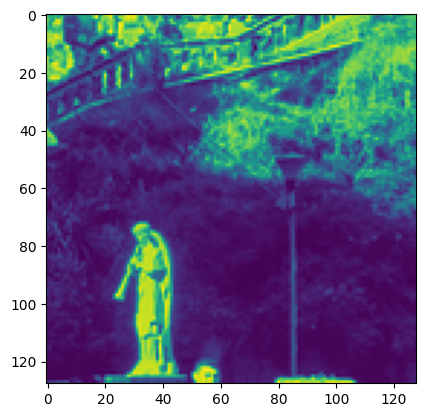

In [9]:
plt.imshow(im[0][0])

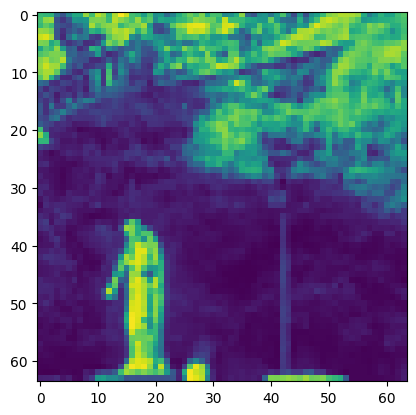

In [10]:
plt.imshow(im[1][0])

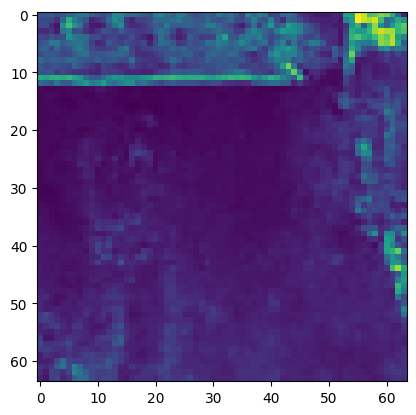

In [3]:
from main import net_fn
import haiku as hk

im = next(a)

network = hk.without_apply_rng(hk.transform(net_fn))
best = None

with open("model.pkl", 'rb') as file:
    import pickle
    best = pickle.load(file)

upscaled = network.apply(best['params'], im.lr)
plt.imshow(im.lr[0])

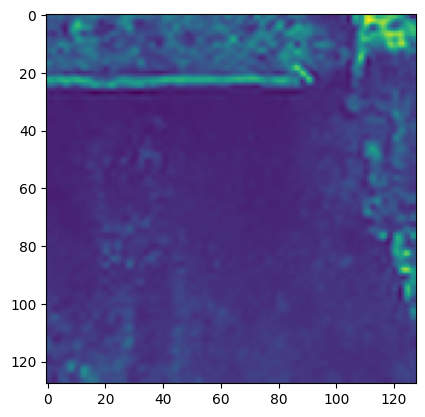

In [4]:
plt.imshow(upscaled[0])

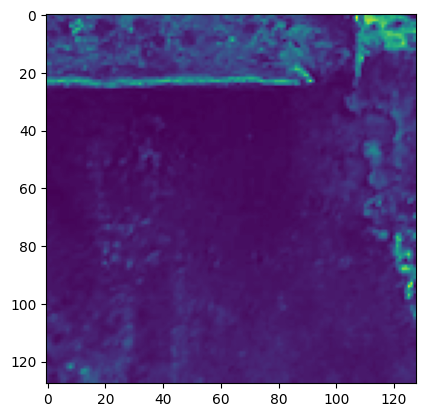

In [5]:
plt.imshow(im.hr[0])